In [2]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [3]:
import pandas as pd
suzuki=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_from_pistachio.csv')

In [4]:
suzuki.head(2)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,0,1,2,3,4,is_base_template
0,1474,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0204,"EXAMPLE 15, Step D",3.1.5,Bromo Suzuki-type coupling,True
1,1485,[CH3:1][c:2]1[cH:3][cH:4][c:5]([n:6]1-[c:7]1[c...,US20010007873A1_0242,"EXAMPLE 20, Step F",3.1.5,Bromo Suzuki-type coupling,True


In [5]:
#data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/data_with_ASKCOS_score.csv')
data_test=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_with_label_180.csv')

In [6]:
from similarity_v1 import get_rxn_maccs, cal_rxn_dice_similarity, get_max_similarity

In [7]:
from tqdm import tqdm
tqdm.pandas()

In [8]:
suzuki['maccs']=suzuki['0'].apply(lambda x: get_rxn_maccs(x))

In [9]:
data_test['maccs']=data_test['rxn_smiles_x'].progress_apply(lambda x: get_rxn_maccs(x))

100%|██████████| 180/180 [00:00<00:00, 1451.63it/s]


In [10]:
emb_list=suzuki['maccs'].tolist()

In [11]:
data_test['max_maccs_sim']=data_test['maccs'].progress_apply(lambda x: get_max_similarity(x,emb_list))

100%|██████████| 180/180 [00:43<00:00,  4.11it/s]


In [12]:
data_test['max_maccs_sim'].describe()

count    180.000000
mean       0.851921
std        0.089611
min        0.706278
25%        0.757514
50%        0.850332
75%        0.921429
max        1.000000
Name: max_maccs_sim, dtype: float64

In [13]:
data_test.head(1)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0.1,Unnamed: 0,index,rxn_smiles_x,maccs,max_maccs_sim,label_x,rxn_smiles_y,ecfp,max_ecfp_sim,label_y,sim_range
0,0,90004,19432,OCc1c(Cl)ccnc1SCI.OPCCc1cccc(B(O)O)c1>>OCc1c(-...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.741772,N,NaN,NaN,NaN,NaN,0.70-0.75


In [14]:
data_test['label_x'] = data_test['label_x'].replace('S', 'Y')

In [15]:
label_dict = {'N': 0, 'Y': 1}
y_true = data_test['label_x'].map(label_dict).values
y_scores = data_test['max_maccs_sim'].values

<Figure size 640x480 with 0 Axes>

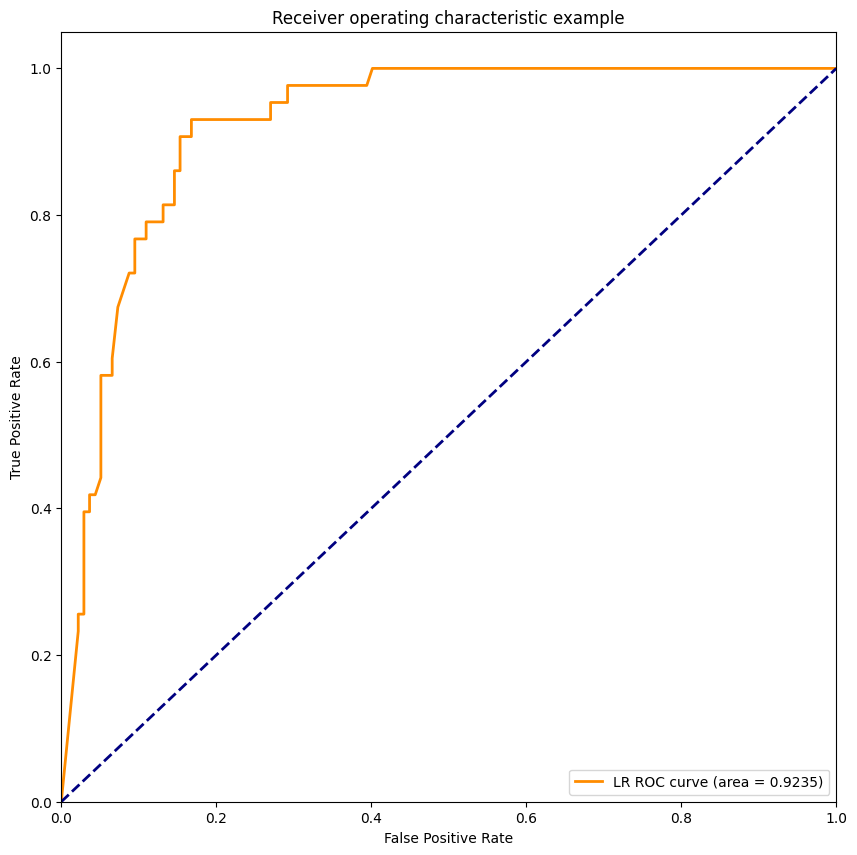

In [17]:
import matplotlib.pyplot as plt
from sklearn import metrics
fpr,tpr,thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)  # 计算auc的值

# 绘制roc曲线
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',lw=lw,label='LR ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/tmp/ipykernel_1919110/2101420121.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_test.groupby(['sim_range', 'label_x']).size().unstack()


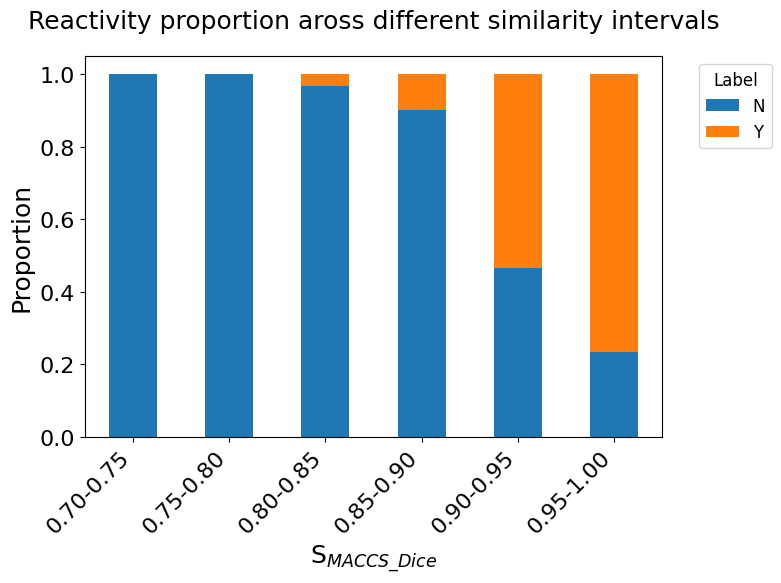

In [18]:
import matplotlib.pyplot as plt
bins = [0.70, 0.75, 0.80, 0.85,0.90,0.95,1.00]
labels = ['0.70-0.75', '0.75-0.80','0.80-0.85', '0.85-0.90','0.90-0.95','0.95-1.00']
data_test['sim_range'] = pd.cut(data_test['max_maccs_sim'], bins=bins, labels=labels)
grouped = data_test.groupby(['sim_range', 'label_x']).size().unstack()

# 计算每个分组中 Y N 的数量，并计算比例
total = grouped.sum(axis=1)
proportions = grouped.apply(lambda x: x / total)

# 设置图表大小和字体大小
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 12

# 绘制堆叠条形图
ax = proportions.plot(kind='bar', stacked=True)

# 设置标题、标签和图例
ax.set_title('Reactivity proportion aross different similarity intervals',fontsize=18,pad=20)
ax.set_xlabel('S$_{MACCS\_Dice}$',fontsize=18)
ax.set_ylabel('Proportion',fontsize=18)
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
#plt.show()
plt.savefig('Figure 5a(YN).png',dpi=600)

In [ ]:
from scipy.stats import spearmanr

# 计算相似度与反应活性之间的斯皮尔曼相关系数
corr, p_value = spearmanr(data_test['max_maccs_sim'], data_test['label_x'], nan_policy='omit')

# 打印相关系数和p值
# print('Spearman correlation coefficient: {:.3f}'.format(corr))
# print('p-value: {:.3f}'.format(p_value))
print('Spearman correlation coefficient: ',corr)
print('p-value:',p_value)


Spearman correlation coefficient:  0.6257527361727342
p-value: 5.902192333385634e-21


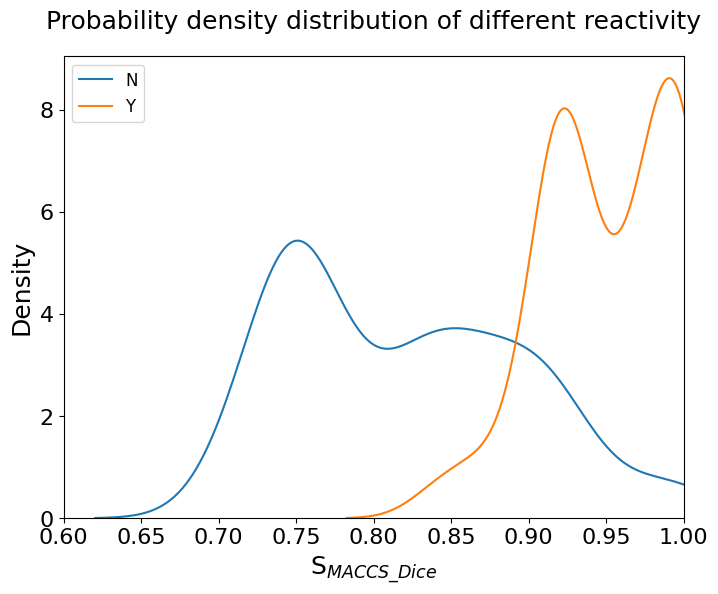

In [20]:
import seaborn as sns
df_Y = data_test[data_test['label_x'] == 'Y'].reset_index(drop=True)
df_N = data_test[data_test['label_x'] == 'N'].reset_index(drop=True)
#df_S = data_test[data_test['label_x'] == 'S'].reset_index(drop=True)
sns.kdeplot(data=df_N['max_maccs_sim'].to_numpy(), label='N')
#sns.kdeplot(data=df_S['max_maccs_sim'].to_numpy(), label='S')
sns.kdeplot(data=df_Y['max_maccs_sim'].to_numpy(), label='Y')
plt.xlabel('S$_{MACCS\_Dice}$',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.title('Probability density distribution of different reactivity',fontsize=18,pad=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.xlim(0.6, 1)
plt.savefig('Figure 6a(YN).png',dpi=600)

##### Analysis of newly generated reactions

In [ ]:
#data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df_subset.csv')
data_generate=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/generate_model/new_rxn_df.csv')

In [ ]:
data_generate['maccs']=data_generate['rxn_smiles'].progress_apply(lambda x: get_rxn_maccs(x))

100%|██████████| 90048/90048 [01:02<00:00, 1431.10it/s]


In [ ]:
data_generate['max_maccs_sim']=data_generate['maccs'].progress_apply(lambda x: get_max_similarity(x,emb_list))

100%|██████████| 90048/90048 [5:47:41<00:00,  4.32it/s]  


In [ ]:
data_generate['max_maccs_sim'].describe()

count    90048.000000
mean         0.876783
std          0.044348
min          0.670045
25%          0.846249
50%          0.877339
75%          0.908177
max          1.000000
Name: max_maccs_sim, dtype: float64

In [ ]:
#data_generate.to_pickle('new_generated_suzuki_with_maccs_sim_true_structure.pkl')

In [44]:

data_generate=pd.read_pickle(('new_generated_suzuki_with_maccs_sim_true_structure.pkl'))

In [45]:
data_generate.head(1)

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim
0,0,Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.0


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Histogram of generated reactions similarity')

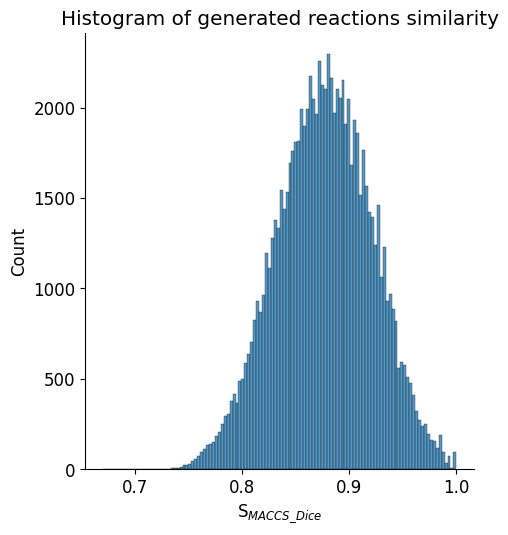

In [47]:
sns.displot(data=data_generate['max_maccs_sim'].to_numpy())
# plt.legend()
plt.xlabel('S$_{MACCS\_Dice}$')
plt.title('Histogram of generated reactions similarity')

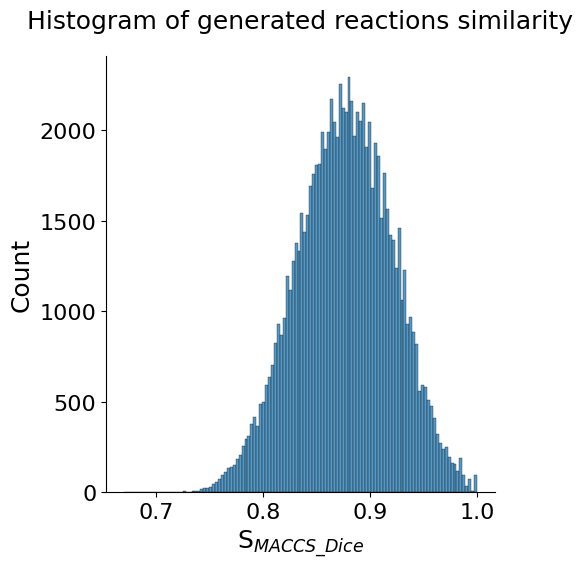

In [65]:
sns.displot(data=data_generate['max_maccs_sim'].to_numpy())
plt.xlabel('S$_{MACCS\_Dice}$',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Histogram of generated reactions similarity',fontsize=18,pad=20)
plt.savefig('Figure 4a(MACCS).jpg',dpi=600,bbox_inches='tight')

Text(0.5, 1.0, 'pdf of generated reactions similarity')

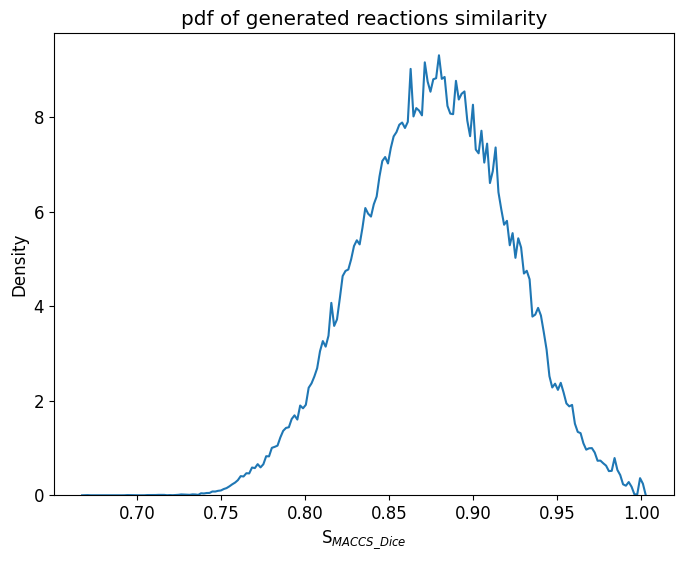

In [49]:
sns.kdeplot(data=data_generate['max_maccs_sim'].to_numpy(), bw_adjust=.2)
plt.xlabel('S$_{MACCS\_Dice}$')
plt.title('pdf of generated reactions similarity')

##### Get sim for new reaction

In [21]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
#from similarity_v1 import get_max_similarity_1
def get_max_similarity_1(rxn,rxn_list):
    sim_list=[]
    for j in rxn_list:
        sim=cal_rxn_dice_similarity(rxn,j)
        if sim!=1:
            sim_list.append(sim)
    max_sim=max(sim_list)
    return max_sim

def get_sim_for_new_reaction(rxn):
    rxn = AllChem.ReactionFromSmarts(rxn,useSmiles=True)
    rxn1=RemoveMappingNumbersFromReactions(rxn)
    rxn=AllChem.ReactionToSmiles(rxn)
    print(rxn)
    maccs=get_rxn_maccs(rxn)
    sim=get_max_similarity_1(maccs,emb_list)
    return sim

In [22]:
def get_max_similarity_uspto(rxn,rxn_list):
    sim_list=[]
    for j in rxn_list:
        sim=cal_rxn_dice_similarity(rxn,j)
        sim_list.append(sim)
        if sim==1:
            break
    max_sim=max(sim_list)
    return max_sim

def get_sim_for_uspto_reaction(rxn):
    rxn = AllChem.ReactionFromSmarts(rxn,useSmiles=True)
    rxn1=RemoveMappingNumbersFromReactions(rxn)
    rxn=AllChem.ReactionToSmiles(rxn)
    #print(rxn)
    maccs=get_rxn_maccs(rxn)
    sim=get_max_similarity_uspto(maccs,emb_list)
    return sim

In [35]:
data_uspto=pd.read_csv('/home/cbe/AI4CHEM/reaction_predict/suzuki_from_uspto.csv')

In [36]:
data_uspto['max_sim']=data_uspto['rxn_smiles'].progress_apply(lambda x: get_sim_for_uspto_reaction(x))

100%|██████████| 1870/1870 [05:25<00:00,  5.74it/s]


In [37]:
data_uspto['max_sim'].describe()

count    1870.000000
mean        0.954618
std         0.045480
min         0.791128
25%         0.920786
50%         0.960935
75%         1.000000
max         1.000000
Name: max_sim, dtype: float64

Text(0.5, 1.0, 'Histogram of uspto reactions similarity')

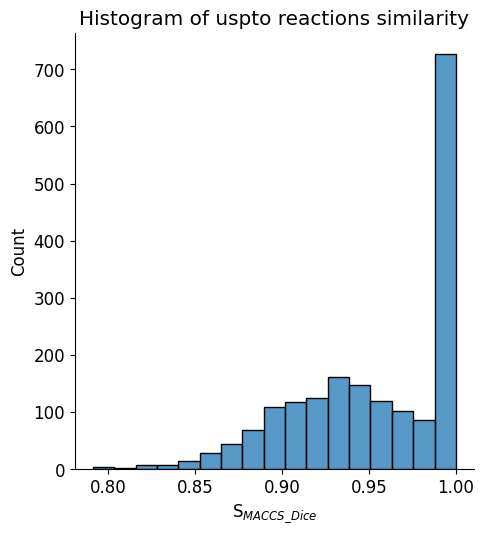

In [39]:
sns.displot(data=data_uspto['max_sim'].to_numpy())
# plt.legend()
plt.xlabel('S$_{MACCS\_Dice}$')
plt.title('Histogram of uspto reactions similarity')

##### Protecting groups analysis

In [52]:
len(emb_list)

115344

#### Suzuki with aldehyde groups

In [23]:
get_sim_for_new_reaction('[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([cH:7][cH:8]1)-[c:9]1[cH:10][cH:11][c:12]([cH:13][cH:14]1)B(O)O.[O:15]=[CH:16][c:17]1[s:18][cH:19][cH:20][c:21]1Br>>[CH3:1][O:2][c:3]1[cH:8][cH:7][c:6]([cH:5][cH:4]1)-[c:9]1[cH:14][cH:13][c:12]([cH:11][cH:10]1)-[c:21]1[cH:20][cH:19][s:18][c:17]1[CH:16]=[O:15]')

COc1ccc(-c2ccc(B(O)O)cc2)cc1.O=Cc1sccc1Br>>COc1ccc(-c2ccc(-c3ccsc3C=O)cc2)cc1


0.927170868347339

In [24]:
get_sim_for_new_reaction('[CH3:1][O:2][c:3]1[cH:8][cH:7][c:6]([c:9]2[cH:14][cH:13][c:12](B(O)O)[cH:11][cH:10]2)[cH:5][cH:4]1.Br[c:20]3[c:16]([CH:15]4OCCO4)[s:17][cH:18][cH:19]3>>[CH3:1][O:2][c:3]5[cH:4][cH:5][c:6]([c:9]6[cH:10][cH:11][c:12]([c:20]7[c:16]([CH:15]8OCCO8)[s:17][cH:18][cH:19]7)[cH:13][cH:14]6)[cH:7][cH:8]5')

Brc1ccsc1C1OCCO1.COc1ccc(c2ccc(B(O)O)cc2)cc1>>COc1ccc(c2ccc(c3ccsc3C3OCCO3)cc2)cc1


0.8828086571569109

In [25]:
get_sim_for_new_reaction('[CH3:1][C:2](=[O:3])[c:4]1[c:5]([c:6]([nH:7][c:8]1Br)-[c:9]1[cH:10][cH:11][n:12][cH:13][cH:14]1)[CH3:15].OB(O)[c:16]1[cH:17][cH:18][c:19]([cH:20][cH:21]1)[F:22]>>[CH3:1][C:2](=[O:3])[c:4]1[c:5]([c:6]([nH:7][c:8]1-[c:16]1[cH:17][cH:18][c:19]([cH:20][cH:21]1)[F:22])-[c:9]1[cH:10][cH:11][n:12][cH:13][cH:14]1)[CH3:15]')

CC(=O)c1c(Br)[nH]c(-c2ccncc2)c1C.OB(O)c1ccc(F)cc1>>CC(=O)c1c(-c2ccc(F)cc2)[nH]c(-c2ccncc2)c1C


0.8898580121703854

In [26]:
get_sim_for_new_reaction('[CH3:1][C:2]1(OCCO1)[c:3]2[c:7](Br)[nH:6][c:5]([c:8]3[cH:13][cH:12][n:11][cH:10][cH:9]3)[c:4]2[CH3:14].OB([c:15]4[cH:20][cH:19][c:18]([F:21])[cH:17][cH:16]4)O>>[CH3:1][C:2]5(OCCO5)[c:3]6[c:7]([c:15]7[cH:20][cH:19][c:18]([F:21])[cH:17][cH:16]7)[nH:6][c:5]([c:8]8[cH:13][cH:12][n:11][cH:10][cH:9]8)[c:4]6[CH3:14]')

Cc1c(C2(C)OCCO2)c(Br)[nH]c1c1ccncc1.OB(O)c1ccc(F)cc1>>Cc1c(C2(C)OCCO2)c(c2ccc(F)cc2)[nH]c1c1ccncc1


0.8399267399267399

In [27]:
get_sim_for_new_reaction('[CH3:1][c:2]1[c:3]([c:4]([s:5][c:6]1I)[CH:7]=[O:8])Br.C[O:9][c:10]1[cH:11][cH:12][c:13]([cH:14][cH:15]1)B(O)O>>[CH3:1][c:2]1[c:6]([s:5][c:4]([c:3]1-[c:13]1[cH:14][cH:15][c:10]([cH:11][cH:12]1)[OH:9])[CH:7]=[O:8])-[c:13]1[cH:14][cH:15][c:10]([cH:11][cH:12]1)[OH:9]')

COc1ccc(B(O)O)cc1.Cc1c(I)sc(C=O)c1Br>>Cc1c(-c2ccc(O)cc2)sc(C=O)c1-c1ccc(O)cc1


0.927170868347339

In [28]:
get_sim_for_new_reaction('[CH3:1][c:2]1[c:6](I)[s:5][c:4]([CH:7]2OCCO2)[c:3]1Br.COc3ccc(B(O)O)cc3>>[CH3:1][c:2]4[c:3](c5ccc(O)cc5)[c:4]([CH:7]6OCCO6)[s:5][c:6]4c7ccc(O)cc7')

COc1ccc(B(O)O)cc1.Cc1c(I)sc(C2OCCO2)c1Br>>Cc1c(c2ccc(O)cc2)sc(C2OCCO2)c1c1ccc(O)cc1


0.8825396825396825

#### Suzuki with NH2

In [31]:
get_sim_for_new_reaction('[CH3:1][c:2]1[cH:3][c:4]([c:5]([c:6]([cH:7]1)Br)[NH2:8])[CH3:9].OB(O)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1>>[CH3:1][c:2]1[cH:7][c:6]([c:5]([c:4]([cH:3]1)[CH3:9])[NH2:8])-[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1')

Cc1cc(C)c(N)c(Br)c1.OB(O)c1ccccc1>>Cc1cc(C)c(N)c(-c2ccccc2)c1


0.9782515991471215

In [32]:
get_sim_for_new_reaction('Cc1cc(C)c(N)c(Br)c1.OB(O)c1ccccc1>>Cc1cc(C)c(N)c(-c2ccccc2)c1')

Cc1cc(C)c(N)c(Br)c1.OB(O)c1ccccc1>>Cc1cc(C)c(N)c(-c2ccccc2)c1


0.9782515991471215

In [33]:
get_sim_for_new_reaction('Cc1cc(Br)c(NC(OCC2=CC=CC=C2)=O)c(C)c1.OB(c1ccccc1)O>>Cc1cc(c2ccccc2)c(NC(OCC3=CC=CC=C3)=O)c(C)c1')

Cc1cc(C)c(NC(=O)OCC2=CC=CC=C2)c(Br)c1.OB(O)c1ccccc1>>Cc1cc(C)c(NC(=O)OCC2=CC=CC=C2)c(c2ccccc2)c1


0.8778424114225277

##### Example 2

In [34]:
get_sim_for_new_reaction('[NH2:1][c:2]1[cH:3][cH:4][cH:5][n:6][c:7]1Cl.OB(O)[c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1>>[NH2:1][c:2]1[cH:3][cH:4][cH:5][n:6][c:7]1-[c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1')

Nc1cccnc1Cl.OB(O)c1ccccc1>>Nc1cccnc1-c1ccccc1


0.9683720930232558

In [35]:
get_sim_for_new_reaction('Cl[c:7]1[c:2]([NH:1]C(OCC2=CC=CC=C2)=O)[cH:3][cH:4][cH:5][n:6]1.OB([c:8]3[cH:13][cH:12][cH:11][cH:10][cH:9]3)O>>O=C(OCC4=CC=CC=C4)[NH:1][c:2]5[c:7]([c:8]6[cH:13][cH:12][cH:11][cH:10][cH:9]6)[n:6][cH:5][cH:4][cH:3]5')

O=C(Nc1cccnc1Cl)OCC1=CC=CC=C1.OB(O)c1ccccc1>>O=C(Nc1cccnc1c1ccccc1)OCC1=CC=CC=C1


0.8721122112211221

#### Suzuki with OH

#### Example1

In [43]:
get_sim_for_new_reaction('[OH:1][CH2:2][c:3]1[cH:4][c:5]([c:6]([c:7]([n:8]1)[Cl:9])[O:10][CH2:11][CH:12]1[CH2:13][CH2:14]1)I.OB(O)[c:15]1[cH:16][cH:17][c:18]([c:19]([cH:20]1)[Cl:21])[Cl:22]>>[OH:1][CH2:2][c:3]1[cH:4][c:5]([c:6]([c:7]([n:8]1)[Cl:9])[O:10][CH2:11][CH:12]1[CH2:13][CH2:14]1)-[c:15]1[cH:16][cH:17][c:18]([c:19]([cH:20]1)[Cl:21])[Cl:22]')

OB(O)c1ccc(Cl)c(Cl)c1.OCc1cc(I)c(OCC2CC2)c(Cl)n1>>OCc1cc(-c2ccc(Cl)c(Cl)c2)c(OCC2CC2)c(Cl)n1


0.9233769852326554

In [37]:
get_sim_for_new_reaction('[Cl:9][c:7]1[n:8][c:3]([CH2:2][O:1]C2CCCCO2)[cH:4][c:5](I)[c:6]1[O:10][CH2:11][CH:12]3[CH2:13][CH2:14]3.OB([c:15]4[cH:20][c:19]([Cl:21])[c:18]([Cl:22])[cH:17][cH:16]4)O>>[Cl:9][c:7]5[n:8][c:3]([CH2:2][O:1]C6CCCCO6)[cH:4][c:5]([c:15]7[cH:20][c:19]([Cl:21])[c:18]([Cl:22])[cH:17][cH:16]7)[c:6]5[O:10][CH2:11][CH:12]8[CH2:13][CH2:14]8')

Clc1nc(COC2CCCCO2)cc(I)c1OCC1CC1.OB(O)c1ccc(Cl)c(Cl)c1>>Clc1ccc(c2cc(COC3CCCCO3)nc(Cl)c2OCC2CC2)cc1Cl


0.9090573921592724

##### Example 2

In [38]:
get_sim_for_new_reaction('[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6]([c:7]([cH:8]1)I)[OH:9].OB(O)[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1>>[N:1]#[C:2][c:3]1[cH:4][cH:5][c:6]([c:7]([cH:8]1)-[c:10]1[cH:15][cH:14][cH:13][cH:12][cH:11]1)[OH:9]')

N#Cc1ccc(O)c(I)c1.OB(O)c1ccccc1>>N#Cc1ccc(O)c(-c2ccccc2)c1


0.9626373626373627

In [39]:
get_sim_for_new_reaction('[N:1]#[C:2][c:3]1[cH:8][c:7](I)[c:6]([O:9]C2CCCCO2)[cH:5][cH:4]1.OB([c:10]3[cH:15][cH:14][cH:13][cH:12][cH:11]3)O>>[N:1]#[C:2][c:3]4[cH:8][c:7]([c:10]5[cH:11][cH:12][cH:13][cH:14][cH:15]5)[c:6]([O:9]C6OCCCC6)[cH:5][cH:4]4')

N#Cc1ccc(OC2CCCCO2)c(I)c1.OB(O)c1ccccc1>>N#Cc1ccc(OC2CCCCO2)c(c2ccccc2)c1


0.9242937853107345

#####  重氮化合物保护(Suzuki Coupling of Protected Aryl Diazonium Ions: Expanding the Knowledge of Triazabutadiene Compatible Reactions)

In [40]:
## protection
get_sim_for_new_reaction('BrC1=CC=C(/N=N/N=C2N(C(C)(C)C)C=CN/2C)C=C1.OB(O)C1=CC=CC=C1>>CN1C=CN(C(C)(C)C)/C1=N/N=N/C2=CC=C(C3=CC=CC=C3)C=C2')

CN1C=CN(C(C)(C)C)/C1=N/N=N/C1=CC=C(Br)C=C1.OB(O)C1=CC=CC=C1>>CN1C=CN(C(C)(C)C)/C1=N/N=N/C1=CC=C(C2=CC=CC=C2)C=C1


0.9009818999171891

In [41]:
# no protection
get_sim_for_new_reaction('N#[N+]C1=CC=C(Br)C=C1.OB(O)C1=CC=CC=C1>>N#[N+]C1=CC=C(C2=CC=CC=C2)C=C1')

N#[N+]C1=CC=C(Br)C=C1.OB(O)C1=CC=CC=C1>>N#[N+]C1=CC=C(C2=CC=CC=C2)C=C1


0.8428571428571429

#### Examples  from Chemarxiv(no bomo)

##### True

In [47]:
# 54 99%
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CC=CN=C1>>CC1(C2)CC2(CC3=CC=CN=C3)C1')

BrC1=CC=CN=C1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CC=CN=C3)(C1)C2


0.7903757415952538

In [48]:
#
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CC=NC=C1>>CC1(C2)CC2(CC3=CC=NC=C3)C1')

BrC1=CC=NC=C1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CC=NC=C3)(C1)C2


0.7903757415952538

In [49]:
##56 39%
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=NC=CC=N1>>CC1(C2)CC2(CC3=NC=CC=N3)C1')

BrC1=NC=CC=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=NC=CC=N3)(C1)C2


0.8201146679407549

In [42]:
##61 90%
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CC(C=CC=C2)=C2N=C1>>CC1(C2)CC2(CC3=CC(C=CC=C4)=C4N=C3)C1 ')

BrC1=CC2=C(C=CC=C2)N=C1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CC4=C(C=CC=C4)N=C3)(C1)C2


0.8528624933119315

##### Unsucessful examples

In [35]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=COC=N1>>CC1(C2)CC2(CC3=COC=N3)C1')

BrC1=COC=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=COC=N3)(C1)C2


0.7765151515151515

In [36]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CSC=N1>>CC1(C2)CC2(CC3=CSC=N3)C1')

BrC1=CSC=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CSC=N3)(C1)C2


0.7796442687747036

In [37]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=NN=NC1>>CC1(C2)CC2(CC3N=NN=C3)C1')

BrC1=NN=NC1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3C=NN=N3)(C1)C2


0.7206388975884748

In [39]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1N=CN=N1>>CC1(C2)CC2(CC3N=NC=N3)C1')

BrC1N=CN=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3N=CN=N3)(C1)C2


0.7143852316266109

In [38]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1N=NN=N1>>CC1(C2)CC2(CC3N=NN=N3)C1')

BrC1N=NN=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3N=NN=N3)(C1)C2


0.7325806451612903

###### hexatomic ring

In [44]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CC=CN=N1>>CC1(C2)CC2(CC3=CC=CN=N3)C1')

BrC1=CC=CN=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CC=CN=N3)(C1)C2


0.7827715355805243

In [45]:
get_sim_for_new_reaction('CC(C(C)(C)O1)(C)OB1C(B2OC(C)(C)C(C)(C)O2)C3(C4)CC4(C)C3.BrC1=CC=NN=N1>>CC1(C2)CC2(CC3=CC=NN=N3)C1')

BrC1=CC=NN=N1.CC12CC(C(B3OC(C)(C)C(C)(C)O3)B3OC(C)(C)C(C)(C)O3)(C1)C2>>CC12CC(CC3=CC=NN=N3)(C1)C2


0.7939571150097466

##### Examples  from Chemarxiv add bomo

##### successful examples

In [75]:
# 53 53%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=CC=CC=N6>>C7(CC89CC(C9)(OCOCC%10=CC=CC=C%10)C8)=CC=CC=N7')

BrC1=CC=CC=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=CC=N4)(C2)C3)C=C1


0.8127544097693351

In [49]:
## successful
# 54 99%
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CC=CN=C6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CC=CN=C7')

BrC1=CC=CN=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=CN=C4)(C2)C3)C=C1


0.8279463655610445

In [50]:
## 55 94%
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CC=NC=C6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CC=NC=C7')

BrC1=CC=NC=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=NC=C4)(C2)C3)C=C1


0.8279463655610445

In [51]:
##56 39%
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=NC=CC=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=NC=CC=N7')

BrC1=NC=CC=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=NC=CC=N4)(C2)C3)C=C1


0.8206484474483299

In [78]:
## 57 38%
get_sim_for_new_reaction('CC1(C)C(C)(C)OB(C(C23CC(C3)(OCOCC4=CC=CC=C4)C2)B5OC(C)(C)C(C)(C)O5)O1.BrC6=CN=CN=C6>>C7(CC89CC(OCOCC%10=CC=CC=C%10)(C9)C8)=CN=CN=C7')

BrC1=CN=CN=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CN=CN=C4)(C2)C3)C=C1


0.8212809917355373

In [68]:
#58 73%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=NC=CN=C6>>C7(CC89CC(C9)(OCOCC%10=CC=CC=C%10)C8)=CN=CC=N7')

BrC1=NC=CN=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CN=CC=N4)(C2)C3)C=C1


0.8166513621059075

In [69]:
## 60 82%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=NC7=C(C=C6)C=CC=C7>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=CC=C(C=CC=C%12)C%12=N8')

BrC1=NC2=C(C=CC=C2)C=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=C5C=CC=CC5=N4)(C2)C3)C=C1


0.8170886075949367

In [52]:
##61 90%
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CC7=C(N=C6)C=CC=C7>>C8(CC9(C%10)CC%10(C9)OCOCC%11=CC=CC=C%11)=CC%12=C(N=C8)C=CC=C%12')

BrC1=CC2=C(C=CC=C2)N=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC5=C(C=CC=C5)N=C4)(C2)C3)C=C1


0.8227065712426805

In [70]:
## 62 71%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC(N=C6)=CC7=C6C=CC=C7>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=CC(C=CC=C%12)=C%12C=N8')

BrC1=CC2=C(C=CC=C2)C=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC5=C(C=CC=C5)C=N4)(C2)C3)C=C1


0.8170886075949367

In [71]:
## 63 55%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=CN=CC7=C6C=CC=C7>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=C(C=CC=C%12)C%12=CN=C8')

BrC1=CN=CC2=C1C=CC=C2.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=C5C=CC=CC5=CN=C4)(C2)C3)C=C1


0.8335839598997494

In [72]:
## 64 88%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=CN=CC7=C6N=CC=C7>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=C(N=CC=C%12)C%12=CN=C8')

BrC1=CN=CC2=C1N=CC=C2.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=C5N=CC=CC5=CN=C4)(C2)C3)C=C1


0.8540781218376847

In [73]:
## 65 72%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=CN=CC7=C6C=CC=N7>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=C(C=CC=N%12)C%12=CN=C8')

BrC1=CN=CC2=C1C=CC=N2.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=C5C=CC=NC5=CN=C4)(C2)C3)C=C1


0.8335357215138636

In [74]:
##  66 57%
get_sim_for_new_reaction('CC1(C(OB(O1)C(B2OC(C(O2)(C)C)(C)C)C34CC(C3)(C4)OCOCC5=CC=CC=C5)(C)C)C.BrC6=CC7=NC=NN7C=C6>>C8(CC9%10CC(C%10)(OCOCC%11=CC=CC=C%11)C9)=CC%12=NC=NN%12C=C8')

BrC1=CC2=NC=NN2C=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC5=NC=NN5C=C4)(C2)C3)C=C1


0.86281179138322

##### unsuccessful examples

In [53]:
## unsuccessful
# 5 ring
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=COC=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=COC=N7')

BrC1=COC=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=COC=N4)(C2)C3)C=C1


0.7904761904761906

In [54]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CSC=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CSC=N7')

BrC1=CSC=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CSC=N4)(C2)C3)C=C1


0.7805173362685746

In [55]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=NN=NC6>>C7(N=NN=C7)CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10')

BrC1=NN=NC1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4C=NN=N4)(C2)C3)C=C1


0.7824937810945274

In [56]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6N=NN=N6>>C7(N=NN=N7)CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10')

BrC1N=NN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4N=NN=N4)(C2)C3)C=C1


0.7840909090909092

In [57]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6N=CN=N6>>C7(N=NC=N7)CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10')

BrC1N=CN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4N=CN=N4)(C2)C3)C=C1


0.7880382775119618

In [58]:
# 6ring
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CC=CN=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CC=CN=N7')

BrC1=CC=CN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=CN=N4)(C2)C3)C=C1


0.8105983255054114

In [61]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CC=NN=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CC=NN=N7')

BrC1=CC=NN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CC=NN=N4)(C2)C3)C=C1


0.8061372422680413

In [62]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CN=NN=C6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CN=NN=C7')

BrC1=CN=NN=C1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CN=NN=C4)(C2)C3)C=C1


0.798839618731869

In [63]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=CN=CN=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=CN=CN=N7')

BrC1=CN=CN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=CN=CN=N4)(C2)C3)C=C1


0.8189149560117301

In [64]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=NC=CN=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=NC=CN=N7')

BrC1=NC=CN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=NC=CN=N4)(C2)C3)C=C1


0.8221884498480243

In [65]:
get_sim_for_new_reaction('CC1(C)C(C)(OB(C(C23CC(OCOCC4=CC=CC=C4)(C3)C2)B5OC(C)(C(C)(O5)C)C)O1)C.BrC6=NN=CN=N6>>C7(CC8(C9)CC9(C8)OCOCC%10=CC=CC=C%10)=NN=CN=N7')

BrC1=NN=CN=N1.CC1(C)OB(C(B2OC(C)(C)C(C)(C)O2)C23CC(OCOCC4=CC=CC=C4)(C2)C3)OC1(C)C>>C1=CC=C(COCOC23CC(CC4=NN=CN=N4)(C2)C3)C=C1


0.8180451127819548